In [12]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [30]:
import numpy as np
import pandas as pd

import keras.backend as K
from keras.utils import plot_model

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Masking, TimeDistributed, LSTM, \
    Bidirectional, Reshape, \
    Embedding, Dropout, Flatten, BatchNormalization, \
    RNN, concatenate, Activation
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras import optimizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import random as rn
import tensorflow as tf


In [14]:
rn.seed(123)
np.random.seed(99)
tf.random.set_seed(1234)
# other parameters
MAX_SEQUENCE_LENGTH = 554 
EMBEDDING_DIM = 300
nb_words = 3438
path = '~/tfg/scripts'

In [15]:
# load feature and labels
feat = np.load(f'{path}/npy/pAA-hsf.npy')
vad = np.load(f'{path}/npy/emotions.npy')

# remove outlier, < 1, > 5
vad = np.where(vad == 5.5, 5.0, vad)
vad = np.where(vad == 0.5, 1.0, vad)

print(f'feat shape: {feat.shape}')
print(f'vad shape: {vad.shape}')

feat shape: (10039, 68)
vad shape: (10039, 3)


In [16]:
# text feature
x_train_text = np.load(f'{path}/npy/text_seq_{MAX_SEQUENCE_LENGTH}.npy')
g_word_embedding_matrix = np.load(f'{path}/npy/embeddings.npy')

print(f'x_train_text shape: {x_train_text.shape}')
print(f'embeddings shape: {g_word_embedding_matrix.shape}')

# maxlen is 554, but we will trim it each sentence to mean+stdev = 58+51 = 109
x_train_text = np.delete(x_train_text, np.s_[:-109], 1)

x_train_text = x_train_text.reshape((10039, 109, 1)) # change: from (10039, max_seq_len) -> (10039, max_seq_len, 1)
print(f'x_train_text shape: {x_train_text.shape}')
x_train_text[0][-5:]


x_train_text shape: (10039, 554)
embeddings shape: (3438, 300)
x_train_text shape: (10039, 109, 1)


array([[   0],
       [   0],
       [   0],
       [ 118],
       [1065]], dtype=int32)

In [17]:
scaler = StandardScaler()
scaler = scaler.fit(feat)
scaled_feat = scaler.transform(feat)
feat = scaled_feat

In [18]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# .reshape(vad.shape[0]*vad.shape[1], vad.shape[2]))
scaler = scaler.fit(vad)
# .reshape(vad.shape[0]*vad.shape[1], vad.shape[2]))
scaled_vad = scaler.transform(vad)
vad = scaled_vad

# Concordance correlation coefficient (CCC)-based loss function - using non-inductive statistics
def ccc(gold, pred):
    gold = K.squeeze(gold, axis=-1)
    pred = K.squeeze(pred, axis=-1)
    gold_mean = K.mean(gold, axis=-1, keepdims=True)
    pred_mean = K.mean(pred, axis=-1, keepdims=True)
    covariance = (gold-gold_mean)*(pred-pred_mean)
    gold_var = K.mean(K.square(gold-gold_mean), axis=-1, keepdims=True)
    pred_var = K.mean(K.square(pred-pred_mean), axis=-1, keepdims=True)
    ccc = K.constant(2.) * covariance / (gold_var + pred_var +
                                         K.square(gold_mean - pred_mean))
    return ccc


def ccc_loss(gold, pred):
    # input (num_batches, seq_len, 1)
    ccc_loss = K.constant(1.) - ccc(gold, pred)
    return ccc_loss



In [19]:
import matplotlib.pyplot as plt
def plot_training(history):
  # summarize history for ccc
  plt.figure(figsize=(10,10))
  plt.plot(history.history['v_ccc'], color='green', label='v_ccc')
  plt.plot(history.history['a_ccc'], color='blue', label='a_ccc')
  plt.plot(history.history['d_ccc'], color='red', label= 'd_ccc')
  plt.title(f'Model Train CCC')
  plt.ylabel('ccc')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10,10))
  plt.plot(history.history['val_v_ccc'], color='green', label= 'val_v_ccc')
  plt.plot(history.history['val_a_ccc'], color='blue', label= 'val_a_ccc')
  plt.plot(history.history['val_d_ccc'], color='red', label= 'val_d_ccc')
  plt.title(f'Model Validation CCC')
  plt.ylabel('ccc')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

  # summarize history for loss
  plt.figure(figsize=(10,10))
  plt.plot(history.history['v_loss'], color='green', label='v_loss')
  plt.plot(history.history['a_loss'], color='blue', label='a_loss')
  plt.plot(history.history['d_loss'], color='red', label= 'd_loss')
  plt.title(f'Model Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,10))
  plt.plot(history.history['val_v_loss'], color='green', label= 'val_v_loss')
  plt.plot(history.history['val_a_loss'], color='blue', label= 'val_a_loss')
  plt.plot(history.history['val_d_loss'], color='red', label= 'val_d_loss')
  plt.title(f'Model Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

In [34]:
def create_model(alpha, beta, gamma):
    # speech network
    input_speech = Input(shape=(1, feat.shape[1]), name='speech_input')
    net_speech = BatchNormalization()(input_speech)
    net_speech = LSTM(50, return_sequences=True)(net_speech) # change: from 256 -> 50
    net_speech = LSTM(25, return_sequences=True)(net_speech) # change: from 256 -> 25
    net_speech = LSTM(25, return_sequences=True)(net_speech) # change: from 256 -> 25

    net_speech = Flatten()(net_speech)
    model_speech = Dropout(0.3)(net_speech)

    # text network
    input_text = Input(shape=(109, 1 )) # change: from (max_seq_len,) -> (max_seq_len, 1)
    net_text = Embedding(nb_words,
                         EMBEDDING_DIM,
                         weights=[g_word_embedding_matrix],
                         trainable=True)(input_text)
    net_text = Reshape((109, EMBEDDING_DIM))(net_text) # change: to adapt to having timesteps now
    net_text = LSTM(256, return_sequences=True)(net_text) 
    net_text = LSTM(128, return_sequences=True)(net_text) # change: from 256 -> 128
    # net_text = LSTM(128, return_sequences=True)(net_text) # added
    net_text = LSTM(128, return_sequences=False)(net_text) # change: from 256 -> 128
    net_text = Dense(64)(net_text)
    model_text = Dropout(0.3)(net_text)
    

    # combined model
    model_combined = concatenate([model_speech, model_text])
    model_combined = Dense(64, activation='relu')(model_combined)
    model_combined = Dense(32, activation='relu')(model_combined)
    model_combined = Dropout(0.4)(model_combined)
    target_names = ('v', 'a', 'd')
    # model_combined = [Dense(1, name=name)(model_combined)
    #                   for name in target_names]
    model_valence = Dense(1, name='v')(model_combined)
    model_arousal = Dense(1, name='a')(model_combined)
    model_dominance = Dense(1, name='d')(model_combined)

    model_combined = [model_valence, model_arousal, model_dominance]

    lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=50,
    decay_rate=0.9)
    opt = optimizers.Adam(learning_rate=lr_schedule)

    model = Model([input_speech, input_text], model_combined)
    model.compile(loss=ccc_loss,
                  loss_weights={'v': alpha, 'a': beta, 'd': gamma},
                  optimizer=opt, metrics=[ccc])
    return model

Iteration 0

Epoch 1/50
25/25 [==============================] - 12s 173ms/step - loss: 0.9344 - v_loss: 0.9473 - a_loss: 0.9021 - d_loss: 0.9082 - v_ccc: 0.0527 - a_ccc: 0.0979 - d_ccc: 0.0918 - val_loss: 0.6042 - val_v_loss: 0.6207 - val_a_loss: 0.5350 - val_d_loss: 0.6271 - val_v_ccc: 0.3793 - val_a_ccc: 0.4650 - val_d_ccc: 0.3729
Epoch 2/50
25/25 [==============================] - 2s 91ms/step - loss: 0.4873 - v_loss: 0.4799 - a_loss: 0.4731 - d_loss: 0.5681 - v_ccc: 0.5201 - a_ccc: 0.5269 - d_ccc: 0.4319 - val_loss: 0.4689 - val_v_loss: 0.4538 - val_a_loss: 0.4626 - val_d_loss: 0.5873 - val_v_ccc: 0.5462 - val_a_ccc: 0.5374 - val_d_ccc: 0.4127
Epoch 3/50
25/25 [==============================] - 2s 91ms/step - loss: 0.3780 - v_loss: 0.3548 - a_loss: 0.3914 - d_loss: 0.5138 - v_ccc: 0.6452 - a_ccc: 0.6086 - d_ccc: 0.4862 - val_loss: 0.4613 - val_v_loss: 0.4306 - val_a_loss: 0.5089 - val_d_loss: 0.5816 - val_v_ccc: 0.5694 - val_a_ccc: 0.4911 - val_d_ccc: 0.4184
Epoch 4/50
25/25 [====

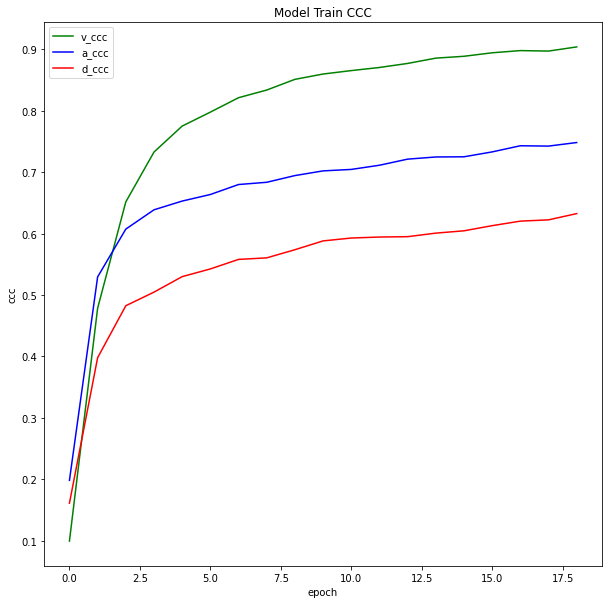

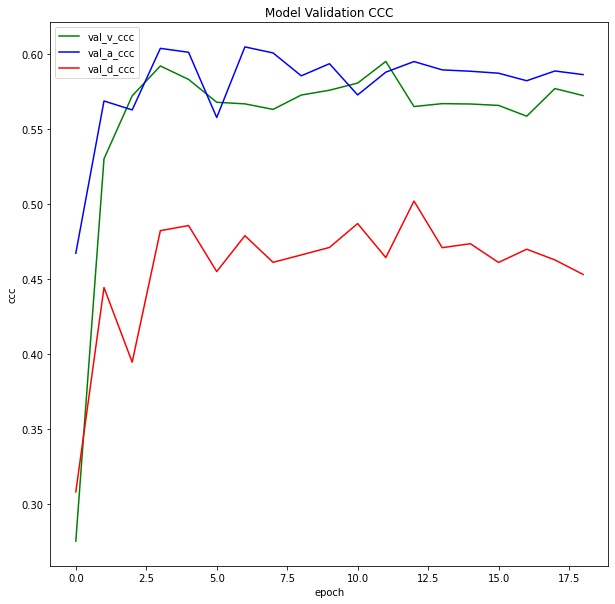

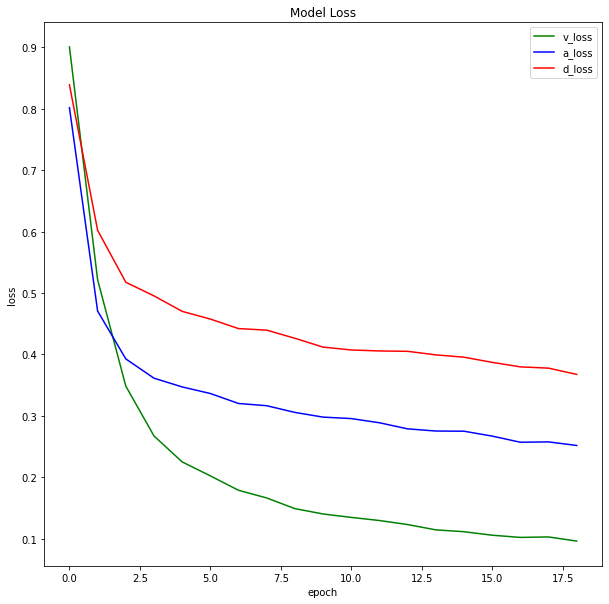

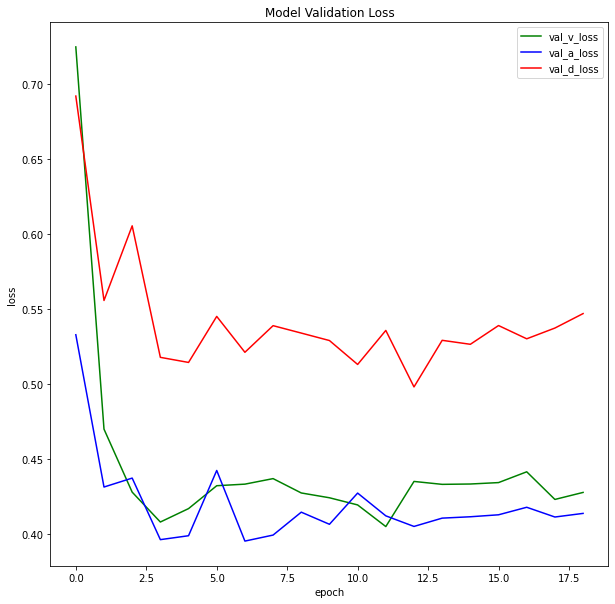

In [35]:
results = []
histories = []
for i in range(10):
  print(f'Iteration {i}\n')
  model = create_model(0.7, 0.2, 0.1)
  plot_model(model, show_shapes=True)

  # 7869 first data of session 5 (for LOSO)
  earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=15, # change: patience from 10 to 15
                            restore_best_weights=True)
  hist = model.fit([feat.reshape(10039, 1, 68)[:7869], x_train_text[:7869]],
                  {"v": vad[:7869].T[0], "a": vad[:7869].T[1],
                      "d": vad[:7869].T[2]},
                  batch_size=256,  # best:8
                  validation_split=0.2, epochs=50, verbose=1, shuffle=True,
                  callbacks=[earlystop])
  metrik = model.evaluate(
      [feat.reshape(10039, 1, 68)[7869:], x_train_text[7869:]],
      {"v": vad[7869:].T[0], "a": vad[7869:].T[1], "d": vad[7869:].T[2]})
  # print("CCC: ", metrik[-3:])  # np.mean(metrik[-3:]))
  # print("CCC_mean: ", np.mean(metrik[-3:]))
  results.append(metrik[-3:])
  histories.append(hist)
  # plot_training(hist)

# visualize trainig
ccc_list = [np.mean(r) for r in results]
v_list = [r[0] for r in results]
a_list = [r[1] for r in results]
d_list = [r[2] for r in results]

print(f'ccc_mean: {np.mean(ccc_list)} +- {np.std(ccc_list)} \n \
        valence_mean: {np.mean(v_list)} +- {np.std(v_list)} \n \
        arousal_mean: {np.mean(a_list)} +- {np.std(a_list)} \n \
        dominance_mean: {np.mean(d_list)} +- {np.std(d_list)} \n' )

print(f'Plot of best model: Model {np.argmax(ccc_list)} \t ccc_mean = {ccc_list[np.argmax(ccc_list)]}\t {results[np.argmax(ccc_list)]}')
plot_training(histories[np.argmax(ccc_list)])